# Sample size calculation


In [ ]:
# import importlib
# importlib.reload(config)
# import utils.config as config

## Get the overall population from GitHub and Kaggle

We sample for GitHub and Kaggle separately

In [ ]:
import pandas as pd
import utils.config as config
import numpy as np

df_err_grouped_k = pd.read_excel(config.path_default.joinpath('clusters_Kaggle.xlsx'))
df_err_grouped_g = pd.read_excel(config.path_default.joinpath('clusters_GitHub.xlsx'))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [ ]:
# for exact an example (random)
# import utils.util as util
# util.print_traceback(df_err_grouped_g[df_err_grouped_g.fname=="00000-1828-homework1-1.ipynb"].iloc[0].traceback)
# df_err_grouped_g[df_err_grouped_g.fname=="00000-1828-homework1-1.ipynb"].iloc[0]

In [9]:
print((df_err_grouped_g.eid.nunique()))
print((df_err_grouped_g.fname.nunique()))

print((df_err_grouped_k.eid.nunique()))
print((df_err_grouped_k.fname.nunique()))

88667
61342
3875
2689


In [10]:
# define sampling methods

import matplotlib.pylab as plt

# calculate variances
def var(p):
    return p*(1-p)

def cal_var(label_config, sample_n0, key="pregroup_cluster"):
    sample_res_vars = {}
    n0 = len(sample_n0)
    for label_key in label_config:
        p = sum(sample_n0[key]==label_key)/n0
        sample_res_vars[label_key] = var(p)
    return sample_res_vars

def plot_var_by_config(sample_vars):
    x, y = list(map(str, sample_vars.keys())), sample_vars.values()
    plt.plot(x, y)
    plt.show()

# calculate overall sample size with respect to variance of clusters
# Confidence level of 0.95
def sample_size(s2, N, e=0.05):
    return 1.96**2 * s2/(e**2 + 1.96**2 * s2 / N)

def sample_sizes_ps(sample_variances, df_err_grouped):
    res_sample_size = {}
    for key, value in sample_variances.items():
        res_sample_size[key] = sample_size(value, len(df_err_grouped))
    return res_sample_size

## We estimate the variances based on manually labeling an initial sample

Here the attribute used is that if a bug if ML bug or not.
This actually doesnt matter much in the results, just an estimation on one aspect of interest.

In [ ]:
# sampling, multinomial based on label_if_ML_bug

import pandas as pd
import utils.config as config

# preliminary estimation of variance of the errors (prior, do not matter much)
df_mlerr_labels_0 = pd.read_csv(config.path_default.joinpath('clusters_sampled_init_labeled.csv'),
                                header=0, encoding='ISO-8859-1', keep_default_na=False)
df_mlerr_label_config = pd.read_csv(config.path_default.joinpath('clusters_sampled_init_Config.csv'),
                                    header=0,
                                    encoding='ISO-8859-1',
                                    keep_default_na=False)

In [12]:
label_config = df_mlerr_label_config[df_mlerr_label_config.label_if_ML_bug!=""].label_if_ML_bug.unique()
sample_labels0_g = df_mlerr_labels_0[(df_mlerr_labels_0.nb_source == config.NB_SOURCE["github"])]
sample_labels0_k = df_mlerr_labels_0[(df_mlerr_labels_0.nb_source == config.NB_SOURCE["kaggle"])]

In [13]:
print(len(sample_labels0_g))
print(sample_labels0_g.label_if_ML_bug.value_counts())
print("\n")
print(len(sample_labels0_k))
print(sample_labels0_k.label_if_ML_bug.value_counts())

394
label_if_ML_bug
ML/data science library related (ML imports, error raised by library)    244
general code error                                                       149
unknown                                                                    1
Name: count, dtype: int64


324
label_if_ML_bug
ML/data science library related (ML imports, error raised by library)    199
general code error                                                       123
unknown                                                                    2
Name: count, dtype: int64


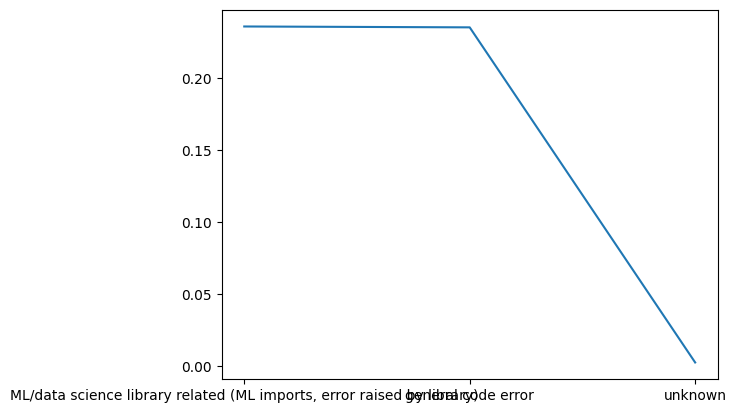

The largest desired sample size is 360


{'ML/data science library related (ML imports, error raised by library)': 360.81938539865354,
 'general code error': 359.8866336836006,
 'unknown': 3.8900321155669544}

In [14]:
# github
sample_variances_g = cal_var(label_config, sample_labels0_g, key = 'label_if_ML_bug')
plot_var_by_config(sample_variances_g)
res_sample_sizes_g = sample_sizes_ps(sample_variances_g, df_err_grouped_g)
sample_size_g = int(max(res_sample_sizes_g.values()))
print("The largest desired sample size is", sample_size_g)
res_sample_sizes_g

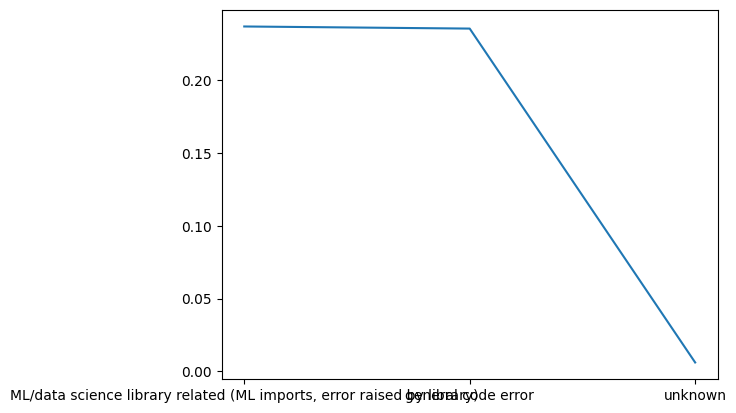

The largest desired sample size is 332


{'ML/data science library related (ML imports, error raised by library)': 332.84431362171534,
 'general code error': 330.9841738176651,
 'unknown': 9.404002525216}

In [15]:
# kaggle
sample_variances_k = cal_var(label_config, sample_labels0_k, key = 'label_if_ML_bug')
plot_var_by_config(sample_variances_k)
res_sample_sizes_k = sample_sizes_ps(sample_variances_k, df_err_grouped_k)
sample_size_k = int(max(res_sample_sizes_k.values()))
print("The largest desired sample size is", sample_size_k)
res_sample_sizes_k

## Proportional sampling to cluster sizes

Based on the total sample size, do the sampling for github and kaggle, taking into account the clusters

In [16]:
import math
pd.set_option('display.max_rows', None)

def cluster_sample_strata_porpotional(sample_size_overall, n_population, cluster_size):
    return math.ceil(sample_size_overall/n_population*cluster_size)

selected_clusters_k = df_err_grouped_k.groupby('cluster_id').size().sort_values(ascending=False).to_frame().reset_index().rename(columns = {0:'cluster_size'})
selected_clusters_g = df_err_grouped_g.groupby('cluster_id').size().sort_values(ascending=False).to_frame().reset_index().rename(columns = {0:'cluster_size'})

In [17]:
# porpotion of clusters in github dataset
selected_clusters_g['sample_size'] = selected_clusters_g['cluster_size'].apply(lambda x: cluster_sample_strata_porpotional(sample_size_g, len(df_err_grouped_g), x))
print("overall sample size for github is", sum(selected_clusters_g.sample_size))
selected_clusters_g

overall sample size for github is 390


,cluster_id,cluster_size,sample_size
0,-200,25840,105
1,1431,24028,98
2,273,5882,24
3,20,5012,21
4,7432,4410,18
5,9,3238,14
6,7430,1444,6
7,268,1270,6
8,239,897,4
9,3331,862,4


In [18]:
# porpotion of clusters in kaggle dataset
selected_clusters_k['sample_size'] = selected_clusters_k['cluster_size'].apply(lambda x: cluster_sample_strata_porpotional(sample_size_k, len(df_err_grouped_k), x))
print("overall sample size for kaggle is", sum(selected_clusters_k.sample_size))
selected_clusters_k

overall sample size for kaggle is 356


,cluster_id,cluster_size,sample_size
0,-100,1140,98
1,1431,1042,90
2,273,225,20
3,7432,210,18
4,9,172,15
5,20,124,11
6,1835,64,6
7,7430,53,5
8,7429,53,5
9,1121,47,5


In [19]:
pd.set_option('display.max_rows', 8)

In [ ]:
# selected_clusters_g.to_excel(config.path_default.joinpath("df_err_processed_pregroup_cluster_size_samples_g.xlsx"), index=False, engine='xlsxwriter')
# selected_clusters_k.to_excel(config.path_default.joinpath("df_err_processed_pregroup_cluster_size_samples_k.xlsx"), index=False, engine='xlsxwriter')

In [24]:
print(sum(selected_clusters_g.cluster_size))
print(sum(selected_clusters_k.cluster_size))

88667
3875


In [6]:
print(sum(selected_clusters_g.sample_size))
print(sum(selected_clusters_k.sample_size))

390
356


## Sample errors for manual labeling

In [ ]:
import pandas as pd
import utils.config as config
import numpy as np

df_err_grouped_k = pd.read_excel(config.path_default.joinpath('clusters_Kaggle.xlsx'))
df_err_grouped_g = pd.read_excel(config.path_default.joinpath('clusters_GitHub.xlsx'))
# selected_clusters_g = pd.read_excel(config.path_default.joinpath('df_err_processed_pregroup_cluster_size_samples_g.xlsx'))
# selected_clusters_k = pd.read_excel(config.path_default.joinpath('df_err_processed_pregroup_cluster_size_samples_k.xlsx'))

# already labeled (in a pilot study)
df_mlerr_labels_0 = pd.read_csv(config.path_default.joinpath('clusters_sampled_pilot_labeled.csv'),
                                header=0, encoding='ISO-8859-1', keep_default_na=False)
df_mlerr_label_config = pd.read_csv(config.path_default.joinpath('clusters_sampled_pilot_labeled_Config.csv'),
                                    header=0,
                                    encoding='ISO-8859-1',
                                    keep_default_na=False)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
# some processing
df_mlerr_labels_0["Comment"].replace("0","", inplace=True)
df_mlerr_labels_0["Other"].replace("0","", inplace=True)
df_mlerr_labels_0.drop_duplicates(subset=['eid'], keep='first', inplace = True)

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_8620\2920300630.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mlerr_labels_0["Comment"].replace("0","", inplace=True)
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_8620\2920300630.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [3]:
# map cluster id
d = dict(zip(df_err_grouped_g.eid, df_err_grouped_g.cluster_id))
dk = dict(zip(df_err_grouped_k.eid, df_err_grouped_k.cluster_id))
d.update(dk)
df_mlerr_labels_0['cluster_id'] = df_mlerr_labels_0['eid'].map(d)

In [4]:
df_mlerr_labels_0.pregroup_cluster.nunique()

29

In [5]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

sample_g_all = None
sample_k_all = None

for _, row in selected_clusters_g.iterrows():
    sc_id = row.cluster_id
    df_sample_size_g = selected_clusters_g[selected_clusters_g.cluster_id==sc_id]
    sample_size_g = df_sample_size_g.sample_size.iloc[0] if len(df_sample_size_g) > 0 else 0
    
    # github
    df_already_sampled_g = df_mlerr_labels_0.loc[(df_mlerr_labels_0.cluster_id == sc_id)&(df_mlerr_labels_0.nb_source == config.NB_SOURCE["github"])]
    if len(df_already_sampled_g) >= sample_size_g:
        # downsampling
        sample_g = df_already_sampled_g.sample(n=sample_size_g, random_state=7)
    else:
        # sample more, not repeat
        tmp_g = df_err_grouped_g[(df_err_grouped_g.cluster_id == sc_id)]
        tmp_g = filter_rows_by_values(tmp_g, "eid", df_already_sampled_g.eid.tolist())
        sample_g = tmp_g.sample(n=(sample_size_g-len(df_already_sampled_g)), random_state=20)
        sample_g = pd.concat([df_already_sampled_g, sample_g], ignore_index=True)

    assert(sample_g.eid.nunique()==sample_size_g)
    
    if sample_g_all is None:
        sample_g_all = sample_g
    else:
        sample_g_all = pd.concat([sample_g_all, sample_g], ignore_index=True)
    
for _, row in selected_clusters_k.iterrows():
    sc_id = row.cluster_id
    df_sample_size_k = selected_clusters_k[selected_clusters_k.cluster_id==sc_id]
    sample_size_k = df_sample_size_k.sample_size.iloc[0] if len(df_sample_size_k) > 0 else 0
    
    # kaggle
    df_already_sampled_k = df_mlerr_labels_0.loc[(df_mlerr_labels_0.cluster_id == sc_id)&(df_mlerr_labels_0.nb_source == config.NB_SOURCE["kaggle"])]
    if len(df_already_sampled_k) >= sample_size_k:
        # downsampling
        sample_k = df_already_sampled_k.sample(n=sample_size_k, random_state=7)
    else:
        # sample more, not repeat
        tmp_k = df_err_grouped_k[(df_err_grouped_k.cluster_id == sc_id)]
        tmp_k = filter_rows_by_values(tmp_k, "eid", df_already_sampled_k.eid.tolist())
        sample_k = tmp_k.sample(n=sample_size_k-len(df_already_sampled_k), random_state=20)
        sample_k = pd.concat([df_already_sampled_k, sample_k], ignore_index=True)
    assert(sample_k.eid.nunique()==sample_size_k)
    
    if sample_k_all is None:
        sample_k_all = sample_k
    else:
        sample_k_all = pd.concat([sample_k_all, sample_k], ignore_index=True)
        
sample_all = pd.concat([sample_g_all, sample_k_all], ignore_index=True)

In [6]:
assert(sample_all.cluster_id.nunique()==len(set(selected_clusters_g.cluster_id.values).union(set(selected_clusters_k.cluster_id.values))))
assert(sample_all.eid.nunique()==(sum(selected_clusters_g.sample_size)+sum(selected_clusters_k.sample_size)))

In [7]:
# sort based on cluster id for better manual labeling
sample_all["size_counts"] = sample_all["cluster_id"].map(sample_all["cluster_id"].value_counts())
assert(len(sample_all[sample_all["size_counts"]==1].cluster_id)==sample_all[sample_all["size_counts"]==1].cluster_id.nunique())
sample_all.sort_values(by='size_counts', ascending=False, inplace=True) # by=['size_counts',"cluster_id"]

In [8]:
# change column position
sample_all.insert(9, 'cluster_id', sample_all.pop('cluster_id'))

In [9]:
sample_all.columns

Index(['fname', 'eid', 'ename', 'evalue', 'traceback', 'ename_mapped',
       'nb_source', 'evalue_processed', 'pregroup_cluster', 'cluster_id',
       'label_ML_pipeline', 'label_if_ML_bug', 'label_refined_exp_type',
       'label_if_runinfo_help', 'label_if_code_error_align',
       'label_if_error_chain', 'label_root_cause', 'Comment', 'Other',
       'imports', 'lib_alias', 'is_MLnb', 'is_relevant', 'if_ast_py23',
       'python_version', 'if_ast', 'hash_evalue_tokenized', 'size_counts'],
      dtype='object')

In [ ]:
import pandas as pd

with pd.ExcelWriter(config.path_default.joinpath("cluster_sampled.xlsx")) as writer:
    sample_all = sample_all.drop(['hash_evalue_tokenized', 'imports', 'lib_alias', 'is_MLnb', 
                                  'is_relevant', 'if_ast_py23', 'python_version', 'if_ast', 'size_counts'], axis=1)
    split_n = len(sample_all)//3
    sample_all[:split_n].to_excel(writer, sheet_name="Del1", index=False)
    sample_all[split_n:split_n*2].to_excel(writer, sheet_name="Del2", index=False)
    sample_all[split_n*2:len(sample_all)].to_excel(writer, sheet_name="Del3", index=False)
    df_mlerr_label_config.to_excel(writer, sheet_name="Config", index=False)
    sample_all = sample_all.drop(['label_ML_pipeline', 'label_if_ML_bug', 'label_refined_exp_type',
                                  'label_if_runinfo_help', 'label_if_code_error_align',
                                  'label_if_error_chain', 'label_root_cause',  'Comment', 'Other'], axis=1)
    sample_all.to_excel(writer, sheet_name="Default", index=False)

In [ ]:
# One could estimate the variances based on clusters to avoid manually labeling. 
# But we already have labelled some and is more interesting
# So the following is not used anymore.
# The results are quite similar though => 368 for GitHub, 323 for Kaggle

# sample_size0_g = int(len(df_err_grouped_g)*0.1)
# sample_size0_k = int(len(df_err_grouped_k)*0.1)

# sample_g = df_err_grouped_g.sample(n=sample_size0_g, random_state=7)
# sample_k = df_err_grouped_k.sample(n=sample_size0_k, random_state=7)

# print((df_err_grouped_g.pregroup_cluster.nunique()))
# print((df_err_grouped_k.pregroup_cluster.nunique()))

In [ ]:
# # sampling, multinomial based on cluster id
# label_config_g = df_err_grouped_g.pregroup_cluster.unique()
# sample_variances_g = cal_var(label_config_g, sample_g)
# plot_var_by_config(sample_variances_g)
# res_sample_sizes_g = sample_sizes_ps(sample_variances_g, df_err_grouped_g)
# sample_size_g = int(max(res_sample_sizes_g.values()))
# print("The largest desired sample size is", sample_size_g)
# res_sample_sizes_g

In [ ]:
# # sampling, multinomial based on cluster id
# label_config_k = df_err_grouped_k.pregroup_cluster.unique()
# sample_variances_k = cal_var(label_config_k, sample_k)
# plot_var_by_config(sample_variances_k)
# res_sample_sizes_k = sample_sizes_ps(sample_variances_k, df_err_grouped_k)
# sample_size_k = int(max(res_sample_sizes_k.values()))
# print("The largest desired sample size is", sample_size_k)
# res_sample_sizes_k